In [2]:
import math
from scipy import interpolate as ip
from numpy import ma
import os
import pdb
from copy import deepcopy
from dataIO.span import span
from matplotlib import pyplot as plt
import numpy as np
import os
from IPython import display

Test methods for loading, resampling, plotting, and saving. I am not sure code is not duplicated of the `points` module.

In [3]:
def load(filename,x=None,y=None,xrange=None,yrange=None,matrix=False,scale=(1.,1.,1.),center=None,skip_header=None,delimiter=','):
    """return a set of xyz points (Npoints,Ndim) from nanovea saved txt (matrix=False)
    or gwyddion saved matrix (matrix=True, xrange, yrange must be defined).
    Scale is used to scale the coordinates (equivalent to points=points*scale)
    Center is the position of the center of the image (before any scaling or rotation) in absolute coordinates.
        Set to (0,0) to center the coordinate system to the data."""
    #2014/04/29 added x and y as preferred arguments to xrange and yrange (to be removed).
    if skip_header==None: 
        skip=0 
    else: 
        skip=skip_header

    if (matrix):
        if ((xrange==None or yrange==None) and (x==None or y==None)): raise Exception
        mdata=np.genfromtxt(filename,skip_header=skip)
        nx,ny= mdata.shape
        if x==None and y==None:
            x=np.linspace(*xrange,num=nx)
            y=np.linspace(*yrange,num=ny)
        #plt.imshow(mdata, extent=(mxrange.min(), myrange.max(), mxrange.max(), myrange.min()))
        xpoints,ypoints=[xy.flatten() for xy in np.array(np.meshgrid(x,y))]
        zpoints=mdata.flatten()
        points=np.vstack([xpoints,ypoints,zpoints]).T
    else:
        points= np.genfromtxt(filename,delimiter=delimiter,skip_header=skip)

    if center != None:
        offset=np.hstack([((np.nanmax(points,axis=0)-np.nanmin(points,axis=0))/2)[0:2],0])-np.array([center[0],center[1],0])
        points=points-offset  #center on 0  
    if scale != None:
        points=points*scale
    return points


In [4]:
class Points(np.ndarray):
    """Represent a set of points in a N-dimensional point cloud, defined as array in format (Npoints,Ndim)."""
    
    method='linear' #default method for interpolation. It can be redefined with Points.method.
    #if set differently in function calls, it is overridden.    
    
    def __new__(cls, filename, *args,**kwargs):
        points=load(filename,*args,**kwargs)
        obj = np.asarray(points).view(cls)
        #obj.info = info
        return obj

    def __array_finalize__(self, obj):
        #print 'In __array_finalize__:'
        #print '   self is %s' % repr(self)
        #print '   obj is %s' % repr(obj)
        if obj is None: return
        self.info = getattr(obj, 'info', None)

    def __array_wrap__(self, out_arr, context=None):
        #print 'In __array_wrap__:'
        #print '   self is %s' % repr(self)
        #print '   arr is %s' % repr(out_arr)
        # then just call the parent
        return np.ndarray.__array_wrap__(self, out_arr, context)   
    
    def translate(self,offset=0):
        """returns translated coordinates of 2D point(s) x ([Npoints x 2]) by an offset.
        It works also on 3-D points, in that case the z is returned unchanged.
        ND."""
        
        #2014/11/26 in class. Replaced old translate with a simple sum of arrays.
        #   The sum is broadcasted whenever it makes sense.
        #It is interesting to notice that calculating the new vector and assigning it to self
        #    with self[:]=translated and returning self
        #    doesn't work, in the sense that the original array is modified and all returned
        #    values point to the same array.
        #2014/08/11 
        #- return a 3d array if a 3d array was passed as argument.
        #- convert the result to array before return.
        #   The result was initially of type np.matrix to simplify operations on extracted columns,
        #   but it didn't really work. The problem is that the result is a matrix and if the
        #   user is unaware of that, all following slicing (column extractions) will be messed up
        #   (vectors will be column vectors as opposite to row vectors returned by np arrays.
                
        return self+offset

    def rotate(self,theta=0,center=(0,0)):
        """returns rotated coordinates of 2D point(s) x ([Npoints x 2]) about a center with anticlockwise angle theta in rad. 
        If 3D points are passed, z coordinate is maintained.
        3D. ugly wrapper around a 2d function (of x and y)."""
        
        if np.size(theta)!=1:
            raise NotImplemented
        
        tx,ty=center
        if (self.shape[-1]==3):
            return np.hstack([self[:,0:2].rotate(theta,center),self[:,2:]])
        else:
            if(self.shape[-1]!=2):
                raise NotImplemented
        x,y=np.array(self[:,0]),np.array(self[:,1])
        cost=math.cos(theta)
        sint=math.sin(theta)
        x1=x*cost-y*sint + ty*sint - tx*(cost-1)
        y1=x*sint+y*cost - tx*sint - ty *(cost-1)
        return np.vstack((x1,y1)).T
    

In [10]:
#filename=r'C:\Users\Vincenzo\Google Drive\libraries\python\userKov\pySurf\test\pointCloud\01_initialization\input\01_OP2S06_CMMsurface.dat'
os.path.curdir
filename=r'pointCloud\01_initialization\input\01_OP2S06_CMMsurface.dat'

p=Points(filename,delimiter='\t')
print (p.rotate())
print (p.rotate(5))
r=p.rotate(np.pi/2)
print (r)
print (p)


[[ -66.862   67.004 -208.344]
 [ -59.662   67.028 -210.662]
 [ -52.306   67.041 -212.756]
 ...
 [  61.03   -72.874 -210.496]
 [  68.302  -72.874 -208.137]
 [  75.485  -72.871 -205.546]]
[[  45.28554106   83.12209593 -208.344     ]
 [  47.35092297   76.22464904 -210.662     ]
 [  49.45000802   69.17448969 -212.756     ]
 ...
 [ -52.56874441  -79.19474659 -210.496     ]
 [ -50.505953    -86.16804391 -208.137     ]
 [ -48.46553075  -93.05514599 -205.546     ]]
[[ -67.004  -66.862 -208.344]
 [ -67.028  -59.662 -210.662]
 [ -67.041  -52.306 -212.756]
 ...
 [  72.874   61.03  -210.496]
 [  72.874   68.302 -208.137]
 [  72.871   75.485 -205.546]]
[[ -66.862   67.004 -208.344]
 [ -59.662   67.028 -210.662]
 [ -52.306   67.041 -212.756]
 ...
 [  61.03   -72.874 -210.496]
 [  68.302  -72.874 -208.137]
 [  75.485  -72.871 -205.546]]


In [12]:
print (p)
print (r)

[[ -66.862   67.004 -208.344]
 [ -59.662   67.028 -210.662]
 [ -52.306   67.041 -212.756]
 ...
 [  61.03   -72.874 -210.496]
 [  68.302  -72.874 -208.137]
 [  75.485  -72.871 -205.546]]
[[ -67.004  -66.862 -208.344]
 [ -67.028  -59.662 -210.662]
 [ -67.041  -52.306 -212.756]
 ...
 [  72.874   61.03  -210.496]
 [  72.874   68.302 -208.137]
 [  72.871   75.485 -205.546]]


In [13]:
filename=r'pointCloud\01_initialization\input\01_OP2S06_CMMsurface.dat'
p=Points(filename,delimiter='\t')
print (p.translate())
print (p.translate(5))
r=p.translate((-1,1,6))
print (id(p),'\n',p)
print (id(r),'\n',r)

[[ -66.862   67.004 -208.344]
 [ -59.662   67.028 -210.662]
 [ -52.306   67.041 -212.756]
 ...
 [  61.03   -72.874 -210.496]
 [  68.302  -72.874 -208.137]
 [  75.485  -72.871 -205.546]]
[[ -61.862   72.004 -203.344]
 [ -54.662   72.028 -205.662]
 [ -47.306   72.041 -207.756]
 ...
 [  66.03   -67.874 -205.496]
 [  73.302  -67.874 -203.137]
 [  80.485  -67.871 -200.546]]
1814454546216 
 [[ -66.862   67.004 -208.344]
 [ -59.662   67.028 -210.662]
 [ -52.306   67.041 -212.756]
 ...
 [  61.03   -72.874 -210.496]
 [  68.302  -72.874 -208.137]
 [  75.485  -72.871 -205.546]]
1814454545768 
 [[ -67.862   68.004 -202.344]
 [ -60.662   68.028 -204.662]
 [ -53.306   68.041 -206.756]
 ...
 [  60.03   -71.874 -204.496]
 [  67.302  -71.874 -202.137]
 [  74.485  -71.871 -199.546]]


resampling...


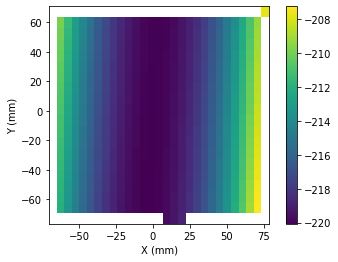

p.plot().shape: (20, 29)


In [29]:
from pySurf.points import resample_grid
method='linear'

def _resample_on_mesh(self,xgrid,ygrid):
    from matplotlib.mlab import griddata
    """resample points [Npoints x 3] on the grid defined by two vectors xgrid [Nx] and ygrid [Ny].
    Return a [Nx * Ny , 3] vector of points, sorted in standard python order
    (x changes faster). To get a (plottable) matrix of data use:
    plt.imshow(rpoints[:,2].reshape(ygrid.size,xgrid.size))."""
    assert self.shape[1]==3
    x,y=np.meshgrid(xgrid,ygrid) #this always return
    z=ip.griddata(self[:,0:2],self[:,2],(x,y),method=method) 
    rpoints=np.vstack([x.flatten(),y.flatten(),z.flatten()]).T   
    #2014/11/24 rpoints=np.vstack([x.T.flatten(),y.T.flatten(),z.T.flatten()]).T
    return rpoints

def _resample_on_points(self,positions):
    """Resample points [Npoints x ndim] on the points defined in positions.
        
    Positions is [Mpoints x ndim-1] or [Mpoints x ndim-1] (in this case, the last column is ignored).
    Return a [Nx x Ny , ndim] vector of points. 
    To get a (plottable) matrix of data use:
    plt.imshow(rpoints[:,ndim-1].reshape(xgrid.size,ygrid.size))."""
    
    points=self.points
    if len(points.shape)==1:
        ndim=1
    else:
        assert len(points.shape)==2
        ndim=(points.shape)[-1]
        
    assert len(positions.shape)==2
    if (positions.shape)[-1]!=ndim-1 and (positions.shape)[-1]!=ndim:
        warn('Positions provided for data interpolation have mismatching dimensions.')
        
    z=ip.griddata(self[:,0:-1],self[:,-1],positions[:,0:ndim],method=self.method)
    rpoints=np.hstack([positions[:,0:ndim],z[:,np.newaxis]])
    return rpoints

'''
def resample(self,positions):
    """resample points [Npoints x 3] on the points defined in positions [Mpoints x 2], or [Mpoints x 3]
    (in this case 3rd column is ignored).
    Return a [Nx x Ny , 3] vector of points. To get a (plottable) matrix of data use:
    plt.imshow(rpoints[:,2].reshape(xgrid.size,ygrid.size))."""
    assert self.shape[1]==3
    z=ip.griddata(self[:,0:2],self[:,-1],positions[:,0:2],method=method)
    rpoints=np.hstack([positions[:,0:2],z[:,np.newaxis]])
    return rpoints
'''        

def to_matrix(points,xgrid=None,ygrid=None,shape=None,matrix=False,fill_value=np.nan,**kwargs):
    """Resample points on a grid based on different possible settings.
    
    """
    
    if shape==None:
        assert len(xgrid.shape)==len(ygrid.shape)==1
    else:
        assert xgrid==ygrid==None
        x,y,z=np.hsplit(self,3)
        xgrid=np.linspace(x.min(),x.max(),shape[0])
        ygrid=np.linspace(y.min(),y.max(),shape[1])
    assert xgrid!=None
    assert ygrid!=None
    grid=np.vstack([g.flatten() for g in  np.meshgrid(xgrid,ygrid)]).T
    points=ip.griddata(self[:,0:2],self[:,2],grid,fill_value=fill_value,method=method)
    points=self.reshape(ygrid.size,xgrid.size)

""" save and plot use the same interface"""

def save(self,filename,xgrid=None,ygrid=None,shape=None,matrix=False,fill_value=np.nan,**kwargs):
    """save points on a file. If matrix is true write in matrix form (in this case you have to 
    provide the values for axis). Otherwise write as points in columns."""
    #2014/08/08 default fill_value modified to nan.
    #20140420 moved filename to second argument for consistency.
    if matrix:
        if shape==None:
            assert len(xgrid.shape)==len(ygrid.shape)==1
        else:
            assert xgrid==ygrid==None
            x,y,z=np.hsplit(self,3)
            xgrid=np.linspace(x.min(),x.max(),shape[0])
            ygrid=np.linspace(y.min(),y.max(),shape[1])
        assert xgrid!=None
        assert ygrid!=None
        grid=np.vstack([g.flatten() for g in  np.meshgrid(xgrid,ygrid)]).T
        points=ip.griddata(self[:,0:2],self[:,2],grid,fill_value=fill_value,method=method)
        points=self.reshape(ygrid.size,xgrid.size)
        #points=np.hstack([grid,self[:,np.newaxis]])
    #if not, they are already in the correct format
    np.savetxt(self,filename,**kwargs)
    
def plot(self,xgrid=None,ygrid=None,shape=None,resample=True,scatter=False,**kwargs):
    """resample xyz points [Nx3] to a grid whose axis xgrid and ygrid are given
    and plot it. If resample is set to False x and y positions are considered only for range, 
    but they are not used to position the z values (it works if x and y are on an exact unrotated grid,
    resampling is slower, but exact)."""

    #plot
    #plt.clf()
    x,y,z=np.hsplit(self,3)
    cmap=kwargs.pop('cmap','jet')
    aspect=kwargs.pop('aspect','equal')
    #pdb.set_trace()
    if scatter: #do scatterplot
        beamsize=20 #I may use this to represent beamsize (round symbol) or lateral resolution (square)
        plt.gca().set_aspect(aspect)
        plt.scatter(x, y, c=z, s=beamsize, cmap=cmap, edgecolors='None', **kwargs)
    else:
        #if not scatter plot, grid must be provided as shape or as xgrid and ygrid axis.
        if shape==None:
            if not len(xgrid.shape)==len(ygrid.shape)==1:
                return z    #skip plot
        else:
            assert xgrid==ygrid==None
            xgrid=np.linspace(x.min(),x.max(),shape[0])
            ygrid=np.linspace(y.min(),y.max(),shape[1])
        if resample:
            print ("resampling...")
            z=resample_grid(self,xgrid,ygrid)[:,2]
        nx,ny=[xx.size for xx in (xgrid,ygrid)]
        xr,yr=[span(xx) for xx in (xgrid,ygrid)]
        xxg,sx=np.linspace(xr[0],xr[1],nx,retstep=1)
        yyg,sy=np.linspace(yr[0],yr[1],ny,retstep=1)
        #ranges for plot (intervals centered on xxg, yyg)
        xr=xr+np.array((-sx/2,sx/2))
        yr=yr+np.array((-sy/2,sy/2))

        z=z.reshape(ny,nx)
        plt.imshow(z,extent=[xr[0],xr[1],yr[0],yr[1]],interpolation='none',aspect=aspect,
            origin='lower')
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.colorbar()
    plt.show()
    return z

Points.save=save
Points.plot=plot
filename=r'pointCloud\01_initialization\input\01_OP2S06_CMMsurface.dat'
p=Points(filename,delimiter='\t')
a=p.plot(shape=(29,20))
print("p.plot().shape:",a.shape)

In [19]:
%qtconsole

In [18]:
gfile=filename
outfolder='OP2S06cmm' 
imsize=(29,20)